In [16]:
import pandas as pd

In [17]:
data = pd.read_csv('ratings.csv')

In [18]:
data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Чтобы посчитать среднее значение рейтинга по фильмам надо для каждого значения movieId получить среднее значение столбца rating. Для этого можем воспользоваться методом groupby:

In [19]:
movie_ID_mean = data.groupby('movieId').mean()

In [20]:
movie_ID_mean.head()

,userId,rating,timestamp
movieId,,,
1,338.558704,3.872470,1.103116e+09
2,318.906542,3.401869,1.069321e+09
3,374.423729,3.161017,9.662429e+08
4,355.538462,2.384615,9.277797e+08
5,320.785714,3.267857,9.967201e+08


Этот метод для каждого значения movieId считает среднее значение каждого столбца (в конце указана функция вычисления среднего mean()).

Сейчас столбец movieId образует индекс строки, т. е. ее номер (из-за этого мы видим смещение в названиях столбцов по вертикали). И мы не можем использовать этот столбец наравне с остальными. Чтобы получить привычный нам датафрейм используем метод reset_index:

In [22]:
movie_ID_mean = movie_ID_mean.reset_index()

In [23]:
movie_ID_mean.head()

,movieId,userId,rating,timestamp
0,1,338.558704,3.872470,1.103116e+09
1,2,318.906542,3.401869,1.069321e+09
2,3,374.423729,3.161017,9.662429e+08
3,4,355.538462,2.384615,9.277797e+08
4,5,320.785714,3.267857,9.967201e+08


отсортируем наш датафрейм по убыванию рейтинга с помощью метода sort_values. Параметр by определяет по каким столбцам будет производиться сортировка (для сортировки по двум и более столбцам используйте вариант by = ['rating', 'userId']). Значение ascending = False указывает, что нам нужна сортировка по убыванию рейтинга:

In [13]:
movie_ID_mean.sort_values( by = 'rating', ascending = False ).head()

,userId,rating,timestamp
movieId,,,
163949,547.0,5.0,1.476419e+09
71180,38.0,5.0,1.389773e+09
51471,20.0,5.0,1.224043e+09
52617,81.0,5.0,1.307173e+09
53887,547.0,5.0,1.201362e+09


Есть подозрение, что фильмы с рейтингом 5.0 на самом деле имеют только одну оценку. Что не особо репрезентативно. Давайте проверим так ли это: выведем на экран все строки датафрейма data, у которых movieId равен 163949. Для этого напишем data[ ... ] и внутри квадратных скобок укажем условие фильтрации. Сейчас нам нужны все строки, у которых значение столбца movieId равно 163949. Синтаксис фильтра будет таким:

In [24]:
data[ data['movieId'] == 163949 ]

,userId,movieId,rating,timestamp
80823,547,163949,5.0,1476419239


Чтобы исключить из статистики фильмы с одной оценкой давайте сначала составим список таких фильмов. Сначала создадим датафрейм movies_count с числом оценок для каждого фильма:

In [25]:
movies_count = data.groupby('movieId').count().reset_index()

Оставим только те фильмы, у которых одна оценка:

In [26]:
movies_with_one_rating = movies_count[ movies_count['rating'] == 1 ]

In [27]:
movies_with_one_rating.head()

,movieId,userId,rating,timestamp
50,53,1,1,1
78,84,1,1,1
88,96,1,1,1
90,98,1,1,1
99,108,1,1,1


Как мы увидим дальше, более простым решением было бы оставить фильмы, у которых более одного рейтинга. Здесь это сделано специально, чтобы показать как использовать фильтр с отрицанием условия с помощью тильды (знак ~).

Теперь можно явно получить список фильмов, которые не следует учитывать при составлении нашего рейтинга. Воспользуемся методом tolist и проверим первые 5 элементов этого листа:

In [28]:
list_of_movies_with_one_rating = movies_with_one_rating['movieId'].tolist()

С помощью этого листа мы можем исключить "нежелательные" ID фильмов из нашего топ-10. Для этого исключим эти ID фильмов из датафрейма data. Метод isin берет только те значения столбца movieId, которые оказались в листе list_of_movies_with_one_rating. А знак тильда в начале условия позволяет "перевернуть" это условие наоборот. Т. е. с этим знаком мы учитываем только те movieId, которые не попали в лист list_of_movies_with_one_rating

In [29]:
data_clean = data[ ~data['movieId'].isin( list_of_movies_with_one_rating ) ]

Выведем обновленную версию нашего рейтинга:

In [36]:
data_clean.groupby('movieId').mean().reset_index().sort_values( by = 'rating', ascending = False ).head()

,movieId,userId,rating,timestamp
3759,6598,214.000000,5.0,1.252122e+09
5682,99764,287.500000,5.0,1.465601e+09
250,309,477.000000,5.0,9.239552e+08
2210,3112,546.666667,5.0,9.618634e+08
3863,6918,229.500000,5.0,1.045089e+09


Не всегда группировки по столбцам достаточно для получения нужных отчетов. Например, довольно часто удобно вывести значения одного из измерений в качестве столбцов. А в качестве значений ячеек (т. е. на пересечении столбцов и строк) вычислять определенное значение. В этом случае нам на помощь приходят сводные таблицы. В Pandas это полный аналог сводных таблиц Excel.

Рассмотрим простой пример с рейтингами фильмов. Нам необходимо узнать какие оценки выставлял каждый пользователь и в каком количестве.

Для каждого пользователя в отдельности такое распределение можно получить следующим образом:

In [37]:
data[ data['userId'] == 1 ]['rating'].value_counts()

2.0    7
3.0    4
4.0    3
2.5    3
1.0    2
3.5    1
Name: rating, dtype: int64

Решим эту задачу сразу для всех пользователей с помощью сводной таблицы:

In [38]:
data.pivot_table(index = 'userId', columns = 'rating', values = 'timestamp', aggfunc = 'count')

rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
userId,,,,,,,,,,
1,NaN,2.0,NaN,7.0,3.0,4.0,1.0,3.0,NaN,NaN
2,NaN,2.0,NaN,4.0,NaN,36.0,NaN,23.0,NaN,11.0
3,NaN,NaN,NaN,1.0,3.0,18.0,9.0,11.0,4.0,5.0
4,NaN,5.0,NaN,5.0,NaN,23.0,NaN,52.0,NaN,119.0
5,NaN,NaN,1.0,NaN,3.0,3.0,27.0,42.0,19.0,5.0
6,1.0,2.0,3.0,7.0,NaN,7.0,3.0,11.0,6.0,4.0
7,NaN,3.0,NaN,5.0,NaN,41.0,NaN,26.0,NaN,13.0
8,1.0,NaN,NaN,3.0,4.0,13.0,26.0,35.0,16.0,18.0
9,NaN,NaN,NaN,5.0,NaN,9.0,NaN,23.0,NaN,8.0


В этом примере использовались следующие основные параметры сводной таблицы:

index - что используем в качестве строк (если нужно использовать несколько столбцов, то пишем index = ['col1', 'col2'])
columns - столбцы сводной таблицы
values - какой столбец используем в качестве значений сводной таблицы
aggfunc - функция, которую используем для вычислений значений сводной таблицы (т. е. values)

У многих пользователей есть оценки, которые они никогда не выставляли. Из-за этого таблица выглядит довольно некрасиво. Заполним эти ячейки нулями с помощью параметра fill_value. Также добавим итоги с помощью параметра margins:

In [39]:
data_pivot = data.pivot_table(index = 'userId', columns = 'rating', values = 'timestamp', aggfunc = 'count', fill_value = 0, margins = True)

In [40]:
data_pivot

rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
userId,,,,,,,,,,,
1,0,2,0,7,3,4,1,3,0,0,20
2,0,2,0,4,0,36,0,23,0,11,76
3,0,0,0,1,3,18,9,11,4,5,51
4,0,5,0,5,0,23,0,52,0,119,204
5,0,0,1,0,3,3,27,42,19,5,100
6,1,2,3,7,0,7,3,11,6,4,44
7,0,3,0,5,0,41,0,26,0,13,88
8,1,0,0,3,4,13,26,35,16,18,116
9,0,0,0,5,0,9,0,23,0,8,45


Сводная таблица имеет тип Pandas dataframe, однако ее индексы немного сбились. Пересчитаем индексы, чтобы работать с data_pivot как с обычным датафреймом. Можно выполнить эту операцию так:

In [44]:
data_pivot = data_pivot.reset_index()

Или можно использовать более сокращенный вариант с помощью параметра inplace:

In [42]:
data_pivot.reset_index(inplace = True)

Получим топ пользователей по количеству выставленных "пятерок":

In [43]:
data_pivot.sort_values(5.0, ascending = False).head()

rating,index,userId,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
671,671,All,1101,3326,1687,7271,4449,20064,10538,28750,7723,15095,100004
563,563,564,0,152,0,187,0,414,0,707,0,408,1868
231,231,232,0,35,0,32,0,96,0,276,0,243,682
241,241,242,0,0,0,4,0,25,0,151,0,219,399
546,546,547,53,79,58,204,177,411,378,591,226,214,2391


Итоговая строка userId = 'All' портит нам статистику. Давайте удалим ее, используя нехитрый прием: оставим только те строки датафрейма data_pivot, у которых значения столбца userId не равны 'All'. Сначала проверим такой фильтр (чтобы случайно не удалить лишнего):

In [46]:
data_pivot[ data_pivot['userId'] == 'All' ]

rating,level_0,index,userId,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
671,671,671,All,1101,3326,1687,7271,4449,20064,10538,28750,7723,15095,100004


Теперь оставляем все строки, исключая userId = 'All' с помощью отрицания условия равенства (!=):

In [47]:
data_pivot = data_pivot[ data_pivot['userId'] != 'All' ]

Теперь можем визуализировать топ нашего рейтинга знакомым способом:

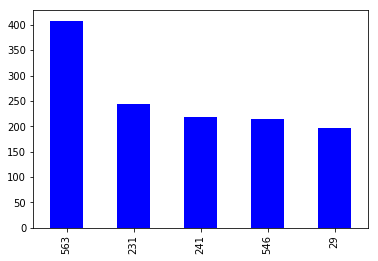

In [49]:
%matplotlib inline
data_pivot.sort_values(5.0, ascending = False)[5.0].head().plot(kind = 'bar', color = ['b'] )

Первый шаг - вычисляем минимальное и максимальное значение timestamp для каждого пользователя. Для подсчета максимума и минимума одновременно используем следующий синтаксис:

In [50]:
userLifetime = data.groupby( 'userId' ).agg([min, max]).reset_index()

In [51]:
userLifetime.head()

userId movieId        rating        timestamp            
             min    max    min  max         min         max
0      1      31   3671    1.0  4.0  1260759108  1260759205
1      2      10    720    1.0  5.0   835355395   835356246
2      3      60  84236    2.0  5.0  1298861589  1298932787
3      4      10   4006    1.0  5.0   949778714   949982274
4      5       3  48385    1.5  5.0  1163373044  1163375145

Теперь считаем разницу в секундах первой и последней оценки:

In [53]:
userLifetime['diff'] = userLifetime['timestamp']['max'] - userLifetime['timestamp']['min']

In [54]:
userLifetime.head()

userId movieId        rating        timestamp                diff
             min    max    min  max         min         max        
0      1      31   3671    1.0  4.0  1260759108  1260759205      97
1      2      10    720    1.0  5.0   835355395   835356246     851
2      3      60  84236    2.0  5.0  1298861589  1298932787   71198
3      4      10   4006    1.0  5.0   949778714   949982274  203560
4      5       3  48385    1.5  5.0  1163373044  1163375145    2101

Осталось усреднить разницу, т. е. посчитать lifetime в секундах:

In [55]:
lifetime = userLifetime['diff'].mean()

Если перевести результат в дни, то получим более наглядную цифру:

In [56]:
print('Lifetime в днях: {:.0f}'.format(lifetime / 3600 / 24))

Lifetime в днях: 201
